# To Do:
- subset wvs dataset down to 250 columns randomly and run all classifiers again

- 

# Import packages

In [98]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import random

# Data Exploration

In [101]:
df = pd.read_csv("C:/Users/aceme/OneDrive/Documents/SIAM Simons Summer Opportunity/Datasets/WVS_Cross-National_Wave_7_csv_v6_0.csv")

C:\Users\aceme\AppData\Local\Temp\ipykernel_34488\3996359589.py:1: DtypeWarning: Columns (346,348,350,580,581,582,583) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/aceme/OneDrive/Documents/SIAM Simons Summer Opportunity/Datasets/WVS_Cross-National_Wave_7_csv_v6_0.csv")


In [102]:
df.head()
df.shape

(97220, 613)

In [103]:
# Column names
print(df.columns.values)

['version' 'doi' 'A_WAVE' 'A_YEAR' 'A_STUDY' 'B_COUNTRY' 'B_COUNTRY_ALPHA'
 'C_COW_NUM' 'C_COW_ALPHA' 'D_INTERVIEW' 'S007' 'J_INTDATE' 'FW_START'
 'FW_END' 'K_TIME_START' 'K_TIME_END' 'K_DURATION' 'Q_MODE' 'N_REGION_ISO'
 'N_REGION_WVS' 'N_REGION_NUTS2' 'N_REG_NUTS1' 'N_TOWN' 'G_TOWNSIZE'
 'G_TOWNSIZE2' 'H_SETTLEMENT' 'H_URBRURAL' 'I_PSU' 'O1_LONGITUDE'
 'O2_LATITUDE' 'L_INTERVIEWER_NUMBER' 'S_INTLANGUAGE' 'LNGE_ISO'
 'E_RESPINT' 'F_INTPRIVACY' 'E1_LITERACY' 'W_WEIGHT' 'S018' 'PWGHT' 'S025'
 'Q1' 'Q2' 'Q3' 'Q4' 'Q5' 'Q6' 'Q7' 'Q8' 'Q9' 'Q10' 'Q11' 'Q12' 'Q13'
 'Q14' 'Q15' 'Q16' 'Q17' 'Q18' 'Q19' 'Q20' 'Q21' 'Q22' 'Q23' 'Q24' 'Q25'
 'Q26' 'Q27' 'Q28' 'Q29' 'Q30' 'Q31' 'Q32' 'Q33' 'Q33_3' 'Q34' 'Q34_3'
 'Q35' 'Q35_3' 'Q36' 'Q37' 'Q38' 'Q39' 'Q40' 'Q41' 'Q42' 'Q43' 'Q44' 'Q45'
 'Q46' 'Q47' 'Q48' 'Q49' 'Q50' 'Q51' 'Q52' 'Q53' 'Q54' 'Q55' 'Q56' 'Q57'
 'Q58' 'Q59' 'Q60' 'Q61' 'Q62' 'Q63' 'Q64' 'Q65' 'Q66' 'Q67' 'Q68' 'Q69'
 'Q70' 'Q71' 'Q72' 'Q73' 'Q74' 'Q75' 'Q76' 'Q77' 'Q78' 'Q79' 'Q80' 'Q

# Data Cleaning

### Subsetting

In [106]:
# Subsetting a random sample of 500 observations 
# df = df.sample(n=500)

# Find index of Q1 to last column & label (Q46)
start_col_index = df.columns.get_loc('Q1')
label_index = df.columns.get_loc('Q46')

# Subsetting to only columns that are Core Questions to Contextual Questinos in WVS CodeBook
df = df.iloc[:,start_col_index:-1]

In [107]:
# Column data types
df.dtypes.values

array([dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
      

### Changing classes for all columns
##### + Drop string columns (NOT DONE TO DO)
##### + Any negative values become NaNs 
##### + Q46 changes from multi-class to binary variable

In [109]:
# Finding columns that are strings
string_vars = df.select_dtypes(include=['object'])
string_vars.columns

# Dropping columns that are strings/objects, these seem to be country-specific variables
df = df.drop(columns=['X002_02B', 'V002A_01', 'V001A_01', 'Partyname', 'Partyabb', 'CPARTY',
       'CPARTYABB'])

In [110]:
# Find index of Q1-Q290 & label (Q46)
start_col_index = df.columns.get_loc('Q1')
label_index = df.columns.get_loc('Q46')

# Checking classes of Q1 & Q46
old_q1 = df.Q1.unique()
old_q46 = df.Q46.unique()

# Define the mapping for missing values
value_mapping = {
    -1: np.nan,
    -2: np.nan,
    -4: np.nan,
    -5: np.nan,
    -999.0: np.nan,
    -9999.0: np.nan
}

# Function to apply the mapping
def map_binary_values(x):
    return value_mapping.get(x, x)

# Apply the mapping only to the specified columns
df.iloc[:,start_col_index:-1] = df.iloc[:,start_col_index:-1].applymap(map_binary_values)

# Define the mapping for missing values
Q46_value_mapping = {
     1: 1,
     2: 1,
     3: 0,
     4: 0,
}

# # Function to apply the mapping
def map_Q46_values(x):
    return Q46_value_mapping.get(x, x)

# # Apply the mapping only to the specified column Q46
df.iloc[:,label_index] = df.iloc[:,label_index].map(map_Q46_values)

# Re-checking classes of Q1 & Q46
new_q1 = df.Q1.unique()
new_q46 = df.Q46.unique()

print("Old Classes: \n", old_q1, old_q46)
print("New Classes: \n", new_q1, new_q46)

C:\Users\aceme\AppData\Local\Temp\ipykernel_34488\3172334349.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.iloc[:,start_col_index:-1] = df.iloc[:,start_col_index:-1].applymap(map_binary_values)


Old Classes: 
 [ 1  2  3  4 -2 -1 -5] [ 1  2  3  4 -1 -2 -5]
New Classes: 
 [ 1.  2.  3.  4. nan] [ 1.  0. nan]


### Dropping rows where Q46 is NaNs

In [112]:
# Drop rows where 'Q46' has NaN values
df = df.dropna(subset=['Q46'])

# Checking if it works
print(df['Q46'].isna().sum())

0


In [113]:
# Column data types to see if we kept any columns that will create issues for our classifiers
df.dtypes.values

array([dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'),

### Dropping columns with too many NaNs

In [115]:
# Checking which columns have 80,000+ NaNs
# Calculate the sum of NaNs in each column
# nan_counts = df.isna().sum()

# Print the result for each column
#for column, count in nan_counts.items():
    #print(f'Column "{column}" has {count} NaN values.')

# Keeping original shape
old_shape = df.shape

# Define the ranges of column names to drop
ranges_to_drop = [
    ('Q82_AFRICANUNION', 'Q82_UNDP'),  # First range
    ('Q291G1', 'Q294B'),  # Second range
    ('ID_GPS', 'v2xnp_client')   # Third range
]

# Create a list to store column names to drop
columns_to_drop = []

# Populate the list with column names from the defined ranges
for start_col, end_col in ranges_to_drop:
    start_idx = df.columns.get_loc(start_col)
    end_idx = df.columns.get_loc(end_col)
    columns_to_drop.extend(df.columns[start_idx:end_idx+1])

# Drop the columns
df = df.drop(columns=columns_to_drop)

In [116]:
# Checking that df size has changed and columns are no longer present
new_shape = df.shape
print("Old Shape:", old_shape)
print("New Shape:", new_shape)
print(df.columns.values)

Old Shape: (96569, 565)
New Shape: (96569, 482)
['Q1' 'Q2' 'Q3' 'Q4' 'Q5' 'Q6' 'Q7' 'Q8' 'Q9' 'Q10' 'Q11' 'Q12' 'Q13'
 'Q14' 'Q15' 'Q16' 'Q17' 'Q18' 'Q19' 'Q20' 'Q21' 'Q22' 'Q23' 'Q24' 'Q25'
 'Q26' 'Q27' 'Q28' 'Q29' 'Q30' 'Q31' 'Q32' 'Q33' 'Q33_3' 'Q34' 'Q34_3'
 'Q35' 'Q35_3' 'Q36' 'Q37' 'Q38' 'Q39' 'Q40' 'Q41' 'Q42' 'Q43' 'Q44' 'Q45'
 'Q46' 'Q47' 'Q48' 'Q49' 'Q50' 'Q51' 'Q52' 'Q53' 'Q54' 'Q55' 'Q56' 'Q57'
 'Q58' 'Q59' 'Q60' 'Q61' 'Q62' 'Q63' 'Q64' 'Q65' 'Q66' 'Q67' 'Q68' 'Q69'
 'Q70' 'Q71' 'Q72' 'Q73' 'Q74' 'Q75' 'Q76' 'Q77' 'Q78' 'Q79' 'Q80' 'Q81'
 'Q82' 'Q83' 'Q84' 'Q85' 'Q86' 'Q87' 'Q88' 'Q89' 'Q90' 'Q91' 'Q92' 'Q93'
 'Q94' 'Q94R' 'Q95' 'Q95R' 'Q96' 'Q96R' 'Q97' 'Q97R' 'Q98' 'Q98R' 'Q99'
 'Q99R' 'Q100' 'Q100R' 'Q101' 'Q101R' 'Q102' 'Q102R' 'Q103' 'Q103R' 'Q104'
 'Q104R' 'Q105' 'Q105R' 'Q106' 'Q107' 'Q108' 'Q109' 'Q110' 'Q111' 'Q112'
 'Q113' 'Q114' 'Q115' 'Q116' 'Q117' 'Q118' 'Q119' 'Q120' 'Q121' 'Q122'
 'Q123' 'Q124' 'Q125' 'Q126' 'Q127' 'Q128' 'Q129' 'Q130' 'Q131' 'Q132'
 'Q133' '

In [117]:
# Checking again to make sure that we don't have a column with 80,000+ NaNs

# Calculate the sum of NaNs in each column
nan_counts = df.isna().sum()

# Print the result for each column
for column, count in nan_counts.items():
    print(f'Column "{column}" has {count} NaN values.')


Column "Q1" has 91 NaN values.
Column "Q2" has 243 NaN values.
Column "Q3" has 449 NaN values.
Column "Q4" has 1008 NaN values.
Column "Q5" has 1082 NaN values.
Column "Q6" has 825 NaN values.
Column "Q7" has 364 NaN values.
Column "Q8" has 999 NaN values.
Column "Q9" has 659 NaN values.
Column "Q10" has 519 NaN values.
Column "Q11" has 1165 NaN values.
Column "Q12" has 610 NaN values.
Column "Q13" has 1077 NaN values.
Column "Q14" has 1095 NaN values.
Column "Q15" has 1071 NaN values.
Column "Q16" has 1087 NaN values.
Column "Q17" has 1153 NaN values.
Column "Q18" has 879 NaN values.
Column "Q19" has 1102 NaN values.
Column "Q20" has 1398 NaN values.
Column "Q21" has 1250 NaN values.
Column "Q22" has 4076 NaN values.
Column "Q23" has 1140 NaN values.
Column "Q24" has 957 NaN values.
Column "Q25" has 2390 NaN values.
Column "Q26" has 1133 NaN values.
Column "Q27" has 1569 NaN values.
Column "Q28" has 1760 NaN values.
Column "Q29" has 2516 NaN values.
Column "Q30" has 1329 NaN values.
C

In [118]:
# Dropping all rows that contain NAs
df = df.dropna()
new_shape = df.shape
print("Old Shape:", old_shape)
print("New Shape:", new_shape)

Old Shape: (96569, 565)
New Shape: (497, 482)


### Subset data such that the entire dataset is only NON-NEGATIVE (for FIC to work)

In [120]:
# Check for columns without negative values
non_negative_columns = df.columns[(df >= 0).all()]

# Subset the DataFrame to include only columns with negative values
df = df[non_negative_columns]

df_shape = df.shape
print("Old Shape:", old_shape)
print("New Shape:", new_shape)

Old Shape: (96569, 565)
New Shape: (497, 482)


### Subset data such that only 250 random columns are selected (for SVM to work)

In [145]:
# Select 250 columns from df, such that Q46 (label) is still included & we still have a mix of floats & integers
df1 = df.iloc[:,0:100]
df2 = df.iloc[:,298:482]
df = pd.concat([df1, df2], axis=1)
df.shape

(497, 250)

# Data Exploration

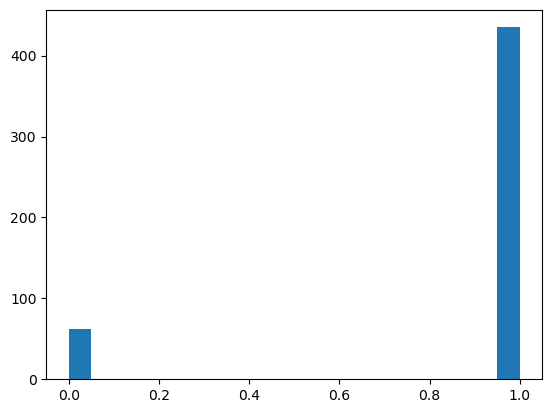

In [52]:
# Create a random number generator with a fixed seed for reproducibility
n_bins = 20

fig, axs = plt.subplots()

# We can set the number of bins with the *bins* keyword argument.
axs.hist(df['Q46'], bins=n_bins)

plt.show()

79.03
69.42


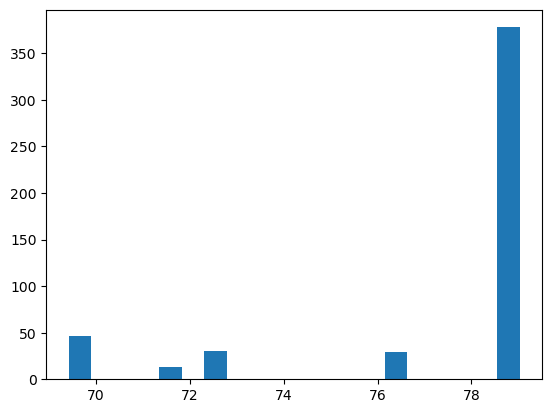

In [54]:
# Reviewing lifeexpect variable
print(df['lifeexpect'].max())
print(df['lifeexpect'].min())

# Histogram of Life Expectancy
n_bins = 20

fig, axs = plt.subplots()

# We can set the number of bins with the *bins* keyword argument.
axs.hist(df['lifeexpect'], bins=n_bins)

plt.show()

# Train test split

In [148]:
# Split dataset into X_train and y_train
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,start_col_index:-1].drop(columns=['Q46']), df.loc[:,'Q46'], test_size=0.2, random_state=42)

# Classifier: XGBoost

In [67]:
# First, put this prompt: "conda install -c conda-forge py-xgboost" in anaconda to download xgboost package
# install xgboost in jupyter
!pip install xgboost

In [150]:
##################################### Classifier: XGBOOST #####################################
# create model instance
# n_estimators: number of trees(estimators) the model uses --> the more used, the more accurate the model is
# max_depth: maximum depth of tree --> higher number makes model more complex, but too high can cause overfitting
# learning_rate: quantifies each tree's contribution to total prediction --> lower number takes longer, but can lead to better generalization
# objective: binary:logistic outputs probabilities. if classification is wanted, use binary:hinge
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic', enable_categorical=True)

# fit model with the training data
bst.fit(X_train, y_train)

# make predictions for the test dataset
preds = bst.predict(X_test)

# print predictions
print(preds)

# print model F1-Score
print("Accuracy:",metrics.f1_score(y_test, preds))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Accuracy: 0.8977272727272728


# SVM

In [72]:
# Subsetting
# df = df.iloc[:,0:50]
# df = df.iloc[:,0:100]
# df = df.iloc[:,0:150]
# df = df.iloc[:,0:200]
# df = df.iloc[:,0:250]
# df = df.iloc[:,0:300] # 25+ minutes and did not finish

In [74]:
# Split dataset into X_train and y_train
# X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,start_col_index:-1].drop(columns=['Q46']), df.loc[:,'Q46'], test_size=0.2, random_state=42)

In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
# kernel: options for kernel include linear, poly, rbf, sigmoid
    # linear: use this when data can be split by a linear function
    # poly (polynomial): use this when data can be split by a polynomial function
    # rbf (radial basis function): use this when there are clusters of one class inside another
    # sigmoid: use this when the split between classes is curved and irregular
clf = svm.SVC(kernel='linear')

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# print predictions
print(y_pred)

# print model F1-Score
print("Accuracy:",metrics.f1_score(y_test, y_pred))

# KNN

In [39]:
#import knn model
from sklearn.neighbors import KNeighborsClassifier

#create a knn classifier
#n_neighbors: predicting the label of the data point by looking at the 3 closest data points and getting them to "vote"
#algorithm: we may need to look at this if it misbehaves
neigh = KNeighborsClassifier(n_neighbors=5)

#train the model using the training sets
neigh.fit(X_train, y_train)

#predict the response for the test dataset
y_pred = neigh.predict(X_test)

#print predictions
print(y_pred)

# print model F1-Score
print("Accuracy:",metrics.f1_score(y_test,y_pred))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
Accuracy: 0.93048128342246


# FIC

In [41]:
class FeatureClassifier:
  def __init__(self,reqAcc = 0.01, classifier = 'DecisionTree', bias = [], control = None, n_jobs = None, random_state = None):
    self.featureClassifiers=[] #list of all the classifiers of all the selected features
    self.reqAcc=reqAcc #user specified cutoff value
    self.indexLs=[] # list of mapped index values to featureClassifiers
    self.flag=0
    self.bias=bias # list of biases for each and every label
    self.control=control #overfitting control for decision trees
    self.classifier=classifier #the classifier which is preferred by the user
    self.dic={'DecisionTree':0,'LinearRegression':1,'SVM':2,'LogisticRegression':3} #a dictionary which maps the classifier to its index
    self.n_jobs=n_jobs
    self.random_state=random_state
    self.num_lables = None

  def finIndex(self):
    #finds the index where the reqAcc condition fails and also created the indexLs[] for mapping
    for i in range(len(self.featureClassifiers)):
      if self.featureClassifiers[i][1] < self.reqAcc:
        return i
      self.indexLs.append(self.featureClassifiers[i][2])
    self.flag=1
    return i

  def fit(self,x,y):
    #applied the model to the dataset. The model is trained and saved for further prediction
    self.num_lables=len(set(y.flatten()))
    bestfeatures = SelectKBest(score_func=chi2,k=1)
    fit = bestfeatures.fit(x,y)

    for i in range(len(x[0])):
      clf=[DecisionTreeClassifier(max_depth=self.control,random_state=self.random_state),LinearRegression(n_jobs=self.n_jobs),SVC(gamma=self.control,random_state=self.random_state), LogisticRegression(penalty=self.control,random_state=self.random_state)][self.dic[self.classifier]]
      X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33,random_state=self.random_state)
      clf.fit(X_train[:,i:i+1],y_train)
      self.featureClassifiers.append((clf,fit.scores_[i],i))
    self.featureClassifiers.sort(key=lambda x:x[1],reverse=True)
    index=self.finIndex()
    if self.flag==0:
      self.featureClassifiers=self.featureClassifiers[:index]
    return

  def predict(self,x):
    #given a list of inputs, predicts the possible outputs
    if not self.bias:
      self.bias=np.zeros(self.num_lables)
    if len(self.bias)<self.num_lables:
      raise AttributeError('Please check the lenth of bias list')
    yPred=[]
    for i in range(len(x)):
      pred_arr=np.zeros(self.num_lables)
      for j in range(len(self.indexLs)):
        pred=np.round(self.featureClassifiers[j][0].predict([[x[i][self.indexLs[j]]]]))
        pred_arr[pred]+=self.featureClassifiers[j][1]+self.bias[pred[0]]
      yPred.append(np.argmax(pred_arr))
    return yPred

In [42]:
# Assuming FeatureClassifier is correctly implemented for DecisionTreeClassifier
clf1 = FeatureClassifier(0, classifier='DecisionTree', control=3, random_state = 42)

# Fit model with the training data
clf1.fit(np.array(X_train), np.array(y_train).astype(int))

# Predict the response for the test dataset
y_pred = clf1.predict(np.array(X_test))

# Calculate and print F1 score
f1 = metrics.f1_score(np.array(y_test).astype(int), y_pred)
print("F1 Score:", f1)

# Print other relevant outputs for debugging
print(clf1.indexLs)

F1 Score: 0.9473684210526316
[390, 389, 388, 393, 314, 401, 383, 300, 303, 297, 315, 384, 385, 237, 238, 239, 293, 287, 289, 288, 403, 420, 203, 208, 194, 50, 206, 205, 193, 405, 122, 306, 49, 51, 311, 59, 279, 48, 176, 196, 172, 424, 195, 363, 248, 4, 171, 111, 191, 0, 262, 267, 425, 1, 257, 268, 220, 112, 192, 266, 113, 255, 190, 199, 417, 364, 103, 271, 95, 272, 115, 240, 202, 296, 218, 302, 260, 269, 274, 204, 2, 307, 136, 57, 41, 119, 421, 91, 310, 322, 305, 235, 114, 309, 357, 249, 250, 236, 259, 294, 123, 350, 52, 395, 104, 174, 216, 312, 367, 160, 106, 161, 368, 151, 96, 77, 200, 78, 263, 273, 397, 396, 159, 105, 76, 46, 398, 207, 131, 419, 53, 316, 107, 222, 140, 147, 201, 55, 144, 79, 275, 26, 54, 110, 361, 93, 245, 109, 43, 71, 221, 56, 29, 81, 32, 298, 61, 74, 358, 291, 75, 359, 70, 209, 116, 100, 299, 330, 149, 166, 99, 101, 270, 345, 89, 254, 402, 127, 369, 130, 332, 323, 331, 198, 362, 360, 244, 173, 133, 150, 326, 329, 324, 276, 335, 42, 9, 182, 280, 148, 304, 66, 414, 